# کتابخانه
<div style="direction:rtl;text-align:right;font-family:Tahoma">
کتابخانه های مورد استفاده</div>

In [18]:
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# دریافت فایل

In [19]:
def get_file(path):
    return pd.read_csv(path)


# قرار دادن نام ستون ها

In [20]:
def set_col_name(N,data_name):
    if(data_name=="train"):
        new_col_names = ["Case", "Site_of_recording","Population_area", "Sex", "Age", "Head_length", "Skull_weight", "Total_length", "Tail_length", "Foot_length", "Ear_conch_length", "Eye", "Chest", "Belly"]
        N.columns = new_col_names

    if(data_name=="test"):
        new_col_names = ["Case", "Site_of_recording","Population_area", "Sex", "Head_length", "Skull_weight", "Total_length", "Tail_length", "Foot_length", "Ear_conch_length", "Eye", "Chest", "Belly"]
        N.columns = new_col_names

# نمایش جداول

<div style="direction:rtl;text-align:right;font-family:Tahoma">
تابع show_details_col(N, text) یک نمودار جعبه‌ای (Boxplot) از ویژگی‌های عددی مجموعه داده رسم می‌کند. همچنین با استفاده از plt.suptitle(text) یک عنوان کلی در بالای پنجره نمایش می‌دهد.
</div>

In [21]:
def show_details_col(N,text):
    numeric_cols = ["Case","Head_length", "Skull_weight", "Total_length", "Tail_length", "Foot_length", "Ear_conch_length", "Eye", "Chest", "Belly"]
    # رسم Boxplot برای بررسی مقادیر پرت
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=N[numeric_cols])
    plt.xticks(rotation=45)
    plt.title("Boxplot of Processed Features")
    # نمایش عنوان کلی در بالای پنجره
    plt.suptitle(text, fontsize=14, fontweight='bold')
    plt.show()

<div style="direction:rtl;text-align:right;font-family:Tahoma"> 
تابع show_feature_importances(model, X_train) میزان اهمیت ویژگی‌های ورودی را از مدل استخراج کرده و به‌صورت نمودار میله‌ای افقی نمایش می‌دهد. این تابع برای تحلیل نقش هر ویژگی در مدل‌های مبتنی بر درخت، مانند جنگل تصادفی (Random Forest)، مفید است.
</div>

In [22]:
def show_feature_importances(model,X_train):
    # دریافت اهمیت ویژگی‌ها
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    # رسم نمودار اهمیت ویژگی‌ها
    feature_importances.sort_values().plot(kind='barh', figsize=(8, 5))
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance in Random Forest Model")
    plt.show()

# نرمال سازی و بهینه سازی داده ها

<div style="direction:rtl;text-align:right;font-family:Tahoma">
این تابع  ستون هایی که قابل استفاده نیستند رو حذف میکنه
</div>

In [23]:
def remove_col(N):
    remove = ["Sex", "Site_of_recording", "Population_area"]
    N = N.drop(columns=remove)
    return N

<div style="direction:rtl;text-align:right;font-family:Tahoma">
این تابع داده‌های پرت را از یک ستون مشخص در دیتافریم حذف می‌کند. برای این کار، از روش IQR (Interquartile Range) استفاده شده است که مقادیر خارج از محدوده‌ی (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR) را حذف می‌کند.</div>

In [24]:
def remove_outliers(df, column):
    """
    حذف داده‌های پرت از یک ستون با استفاده از روش IQR (Interquartile Range)
    
    پارامترها:
    df: دیتافریم pandas
    column: نام ستونی که باید داده‌های پرت آن حذف شود
    
    خروجی:
    دیتافریمی که داده‌های پرت در آن حذف شده‌اند
    """
    Q1 = df[column].quantile(0.25)  # چارک اول (25٪ کمترین مقدارها)
    Q3 = df[column].quantile(0.75)  # چارک سوم (75٪ بیشترین مقدارها)
    IQR = Q3 - Q1  # محدوده بین چارکی
    
    lower_bound = Q1 - 1.5 * IQR  # حد پایین برای پرت‌ها
    upper_bound = Q3 + 1.5 * IQR  # حد بالا برای پرت‌ها
    
    # فیلتر کردن داده‌های داخل محدوده‌ی مجاز
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_cleaned

<div style="direction:rtl;text-align:right;font-family:Tahoma">
این تابع مقادیر پرت یک ستون مشخص را شناسایی کرده و به جای حذف آن‌ها، با میانگین یا میانه جایگزین می‌کند. محدوده‌ی پرت‌ها با استفاده از IQR (Interquartile Range) تعیین شده و مقادیر خارج از محدوده با مقدار جایگزین (میانه یا میانگین) جایگزین می‌شوند.
</div>

In [25]:
def replace_outliers(df, column, method="median"):
    """
    جایگزین کردن داده‌های پرت با میانگین یا میانه
    
    پارامترها:
    df: دیتافریم pandas
    column: نام ستونی که باید داده‌های پرت آن جایگزین شود
    method: "mean" برای جایگزین با میانگین و "median" برای جایگزین با میانه
    
    خروجی:
    دیتافریم با مقدارهای پرت جایگزین‌شده
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # مقدار جایگزین را مشخص کن
    replacement_value = df[column].median() if method == "median" else df[column].mean()

    # جایگزین کردن مقدارهای پرت
    df[column] = df[column].apply(lambda x: replacement_value if (x < lower_bound or x > upper_bound) else x)
    
    return df



<div style="direction:rtl;text-align:right;font-family:Tahoma">
این تابع مقدارهای یک ستون مشخص را با استفاده از نرمال‌سازی خطی (Min-Max Scaling) به بازه‌ی (y1, y2) تبدیل می‌کند. این کار باعث می‌شود مقادیر در یک محدوده‌ی مشخص مقیاس‌بندی شوند و تأثیر مقادیر بزرگ و کوچک کاهش یابد.
</div>

In [26]:
def scale_column_to_range(df, column, y1, y2):
    """
    این تابع مقدارهای ستون مشخص‌شده را به بازه‌ی (y1, y2) تغییر مقیاس می‌دهد.
    
    پارامترها:
    df: دیتافریم پانداس
    column: نام ستونی که باید تغییر کند (مثلاً 'age')
    y1: مقدار حداقل بازه‌ی جدید
    y2: مقدار حداکثر بازه‌ی جدید

    خروجی:
    دیتافریم با مقادیر جدید در همان ستون
    """
    x_min = df[column].min()
    x_max = df[column].max()
    
    # فرمول تبدیل به بازه جدید
    df[column] = (df[column] - x_min) / (x_max - x_min) * (y2 - y1) + y1

    return df

<div style="direction:rtl;text-align:right;font-family:Tahoma">
این تابع داده‌های عددی دیتافریم را با استفاده از StandardScaler استانداردسازی می‌کند، به‌طوری که میانگین برابر با صفر و انحراف معیار برابر با یک باشد. در صورت نیاز می‌توان RobustScaler را نیز برای کاهش تأثیر داده‌های پرت فعال کرد.
</div>

In [27]:
def scaler(N):
    # لیست ستون‌های عددی
    numeric_cols = ["Case", "Head_length", "Skull_weight", "Total_length", 
                    "Tail_length", "Foot_length", "Ear_conch_length", "Eye", "Chest", "Belly"]

    # استانداردسازی داده‌ها
    scalers = {
        'Standard': StandardScaler(),
        'Robust': RobustScaler()
    }

    # اعمال StandardScaler روی برخی از ویژگی‌ها
    standard_cols = ["Case", "Head_length", "Skull_weight", "Total_length", 
                     "Chest", "Belly", "Tail_length", "Foot_length"]
    N.loc[:, standard_cols] = scalers['Standard'].fit_transform(N[standard_cols])

    # اعمال RobustScaler روی برخی ویژگی‌های دیگر
    robust_cols = ["Ear_conch_length", "Eye"]
    N.loc[:, robust_cols] = scalers['Robust'].fit_transform(N[robust_cols])

    return N


<div style="direction:rtl;text-align:right;font-family:Tahoma">
این تابع مقادیر پرت را با استفاده از روش IQR (Interquartile Range) شناسایی کرده و آن‌ها را به نزدیک‌ترین مقدار مجاز (حد بالا یا حد پایین) تغییر می‌دهد. مقدار threshold تعیین می‌کند که چه داده‌هایی پرت محسوب شوند (پیش‌فرض ۱.۵ برابر IQR).
</div>

In [28]:
def remove_outliers_iqr(data, threshold=1.5):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return data.clip(lower=lower_bound, upper=upper_bound)  # جایگزینی مقادیر پرت


<div style="direction:rtl;text-align:right;font-family:Tahoma">
این تابع وینسورایزیشن (Winsorization) را روی یک سری از داده‌ها اعمال می‌کند تا مقادیر پرت را به نزدیک‌ترین مقدار مجاز در محدوده‌ی تعیین‌شده (limits) تغییر دهد. مقدار limits=(0.05, 0.05) یعنی ۵٪ کوچک‌ترین و بزرگ‌ترین مقادیر داده جایگزین شوند.
</div>

In [29]:
def apply_winsorization(series, limits=(0.05, 0.05)):  
    return pd.Series(winsorize(series, limits=limits), index=series.index)

<div style="direction:rtl;text-align:right;font-family:Tahoma">
تابع normalize(N, text) ابتدا مقادیر گمشده را حذف کرده و داده‌ها را با StandardScaler و RobustScaler استانداردسازی می‌کند. سپس مقادیر پرت را با روش IQR حذف کرده و با Winsorization جایگزین می‌کند و در نهایت داده‌ها را برای بررسی نمایش می‌دهد.
</div>

In [30]:
def normalize(N, text):
    """
    این تابع داده‌ها را تمیزسازی، استانداردسازی و نرمال‌سازی می‌کند.
    
    مراحل:
    1. حذف مقادیر گمشده
    2. استانداردسازی با StandardScaler و RobustScaler
    3. حذف و جایگزینی مقادیر پرت
    4. نمایش جعبه‌ای از داده‌ها برای بررسی تغییرات
    """
    numeric_cols = ["Case", "Head_length", "Skull_weight", "Total_length", 
                    "Tail_length", "Foot_length", "Ear_conch_length", "Eye", "Chest", "Belly"]


    # حذف مقادیر گمشده
    N = N.dropna().copy()  
    N = scaler(N)

    # حذف و جایگزینی مقادیر پرت برای تمامی ستون‌های عددی
    for col in numeric_cols:  
        if col in N.columns:  
            N[col] = remove_outliers_iqr(N[col])  # حذف مقادیر پرت با IQR
            N[col] = apply_winsorization(N[col])  # تنظیم مقادیر پرت باقی‌مانده

    # نمایش اطلاعات پس از نرمال‌سازی
    show_details_col(N, text)

    return N


# مدل

<div style="direction:rtl;text-align:right;font-family:Tahoma">
تابع Model(X1, X2, y1, y2) یک مدل جنگل تصادفی (Random Forest Regressor) با ۲۰۰ درخت و عمق حداکثر ۱۵ ایجاد کرده و روی داده‌های آموزشی آموزش می‌دهد. سپس مقدار R²-score را برای داده‌های تست محاسبه و نمایش می‌دهد و در نهایت مدل آموزش‌دیده را برمی‌گرداند.
<div>

In [31]:
def Model(X1, X2, y1, y2):
    # ایجاد مدل Random Forest و آموزش آن
    model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
    model.fit(X1, y1)
    y_pred = model.predict(X2)

    # محاسبه معیارهای ارزیابی
    mae = mean_absolute_error(y2, y_pred)
    rmse = np.sqrt(mean_squared_error(y2, y_pred))
    r2 = r2_score(y2, y_pred)

    # ذخیره نتایج در قالب DataFrame
    results_df = pd.DataFrame({
        "Metric": ["MAE", "RMSE", "R² Score"],
        "Value": [mae, rmse, r2]
    })

    # نمایش نتایج
    print(results_df.to_string(index=False))

    return model


# test

<div style="direction:rtl;text-align:right;font-family:Tahoma">
تابع Test(N, model, output_path) داده‌های جدید را با مدل آموزش‌دیده پیش‌بینی کرده و مقدار "age" را در یک فایل خروجی ذخیره می‌کند. ابتدا داده‌ها از output_path خوانده شده، مقدار age پیش‌بینی می‌شود و در نهایت در "output.csv" ذخیره می‌شود.
</div>

In [32]:
def Test(N,model,output_path):
    output = pd.read_csv(output_path)
    X_new = N.copy() 
    output["age"] = model.predict(X_new) 
    output.to_csv("output.csv", index=False)
    print(" پیش‌بینی مقدار age انجام شد و فایل ذخیره گردید.")


# main

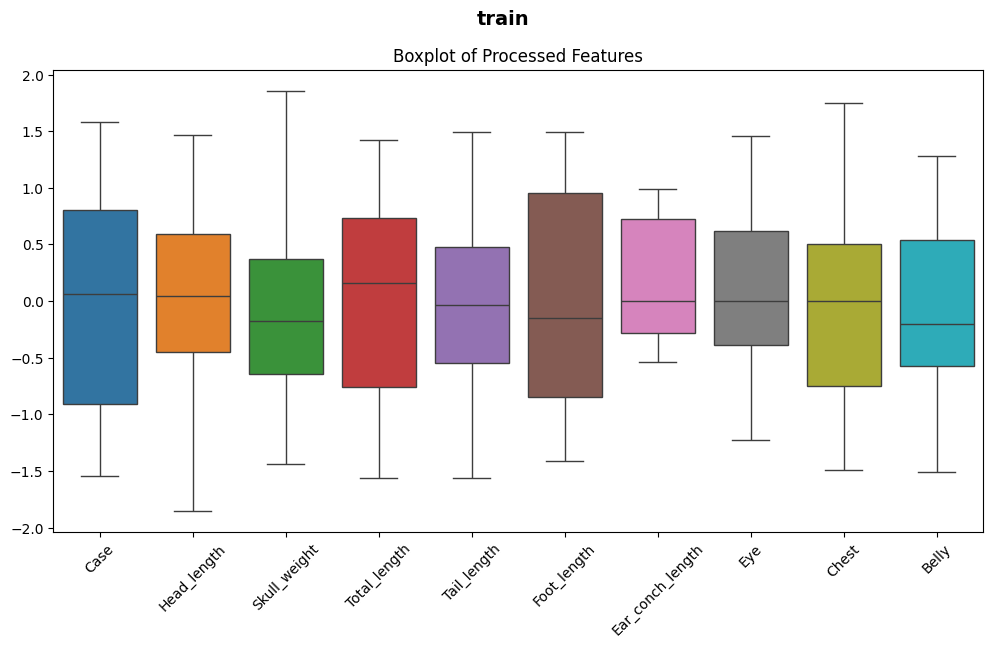

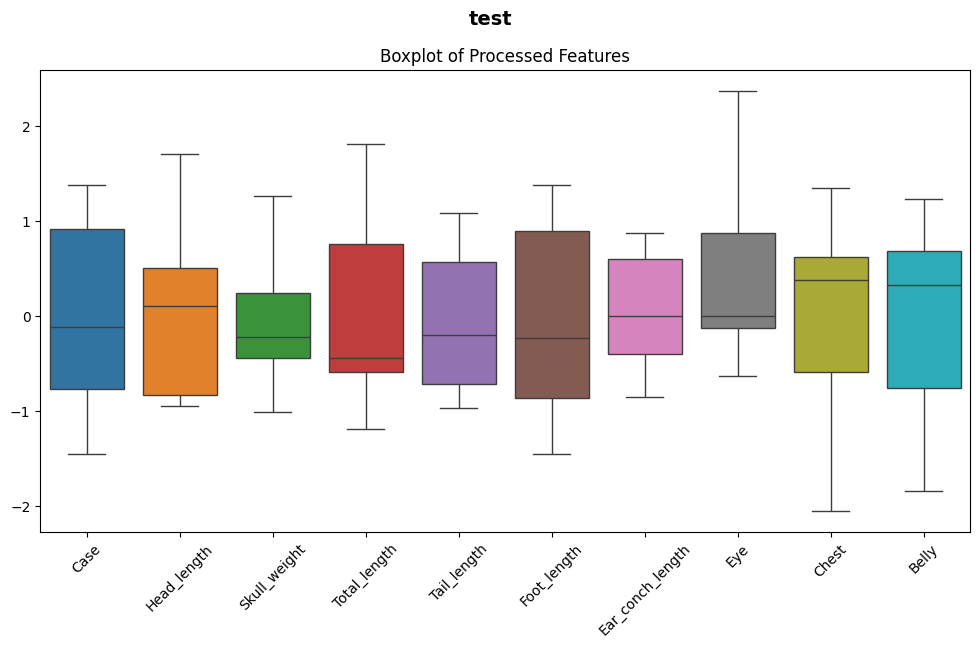

  Metric    Value
     MAE 0.896765
    RMSE 1.138339
R² Score 0.420293
 پیش‌بینی مقدار age انجام شد و فایل ذخیره گردید.


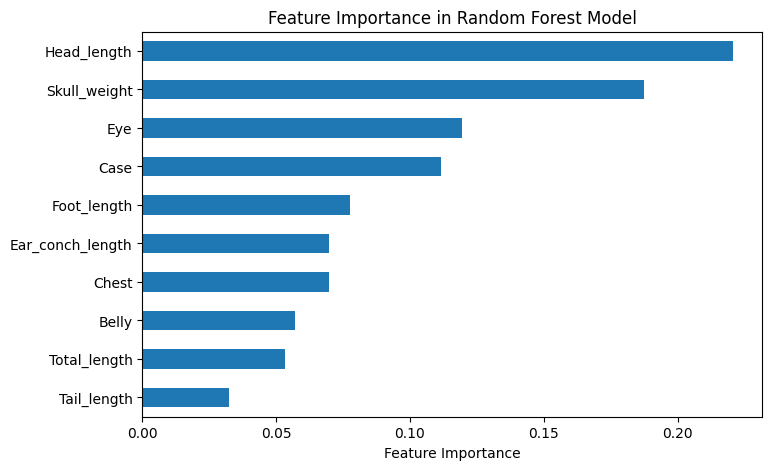

In [33]:
train=get_file("train_data.csv")
test=get_file("test_data.csv")
#-------------------------------
set_col_name(train,"train")
set_col_name(test,"test")
#-------------------------------
train=remove_col(train)
test=remove_col(test)
#-------------------------------
train=normalize(train,"train")
test=normalize(test,"test")
#-------------------------------
X = train.drop(columns = ["Age"])
y = train["Age"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0,shuffle=True)
model=Model(X_train, X_test, y_train, y_test)
#-------------------------------
Test(test,model,"test_data.csv")
#-------------------------------
show_feature_importances(model,X_train)


<div style="direction:rtl;text-align:right;font-family:Tahoma">
نتایج مدل  را بر اساس معیارهای مختلف تحلیل می‌کنم:

1. میانگین قدرمطلق خطا (MAE - Mean Absolute Error)
🔹 مقدار MAE = 0.896 نشان می‌دهد که به‌طور میانگین، پیش‌بینی‌های مدل شما حدود 0.89 واحد از مقادیر واقعی منحرف شده‌اند.
✅ مقدار MAE پایین نشانه‌ی خوبی است، اما به داده‌های شما بستگی دارد که آیا این مقدار برای کاربرد شما قابل‌قبول است یا خیر.

2. ریشه میانگین مربعات خطا (RMSE - Root Mean Squared Error)
🔹 مقدار RMSE = 1.138 نشان می‌دهد که مقدار انحراف مدل از داده‌های واقعی به‌طور میانگین 1.13 واحد است.
❗ معمولاً RMSE همیشه کمی بیشتر از MAE است، زیرا مقادیر بزرگ‌تر خطا را بیشتر مجازات می‌کند.

🔹 مقایسه RMSE و MAE:

اگر RMSE خیلی بزرگ‌تر از MAE باشد، به این معنی است که برخی از پیش‌بینی‌ها دارای خطاهای خیلی بزرگی هستند.

در اینجا اختلاف آن‌ها خیلی زیاد نیست، پس مدل  خطاهای خیلی شدید ندارد.

3. ضریب تعیین (R² Score - Coefficient of Determination)
🔹 مقدار R² = 0.42 نشان می‌دهد که مدل شما 42% از واریانس داده‌ها را توضیح می‌دهد.
❗ مقدار R² نزدیک به 1 نشان‌دهنده مدل بسیار خوب و مقدار نزدیک به 0 یا منفی نشان‌دهنده‌ی مدل ضعیف است.
✅ مقدار 0.42 یعنی مدل تا حدی کار می‌کند، اما هنوز می‌تواند بهتر تنظیم شود.

🔍 نتیجه‌گیری و پیشنهادات برای بهبود مدل
MAE و RMSE نسبتاً خوب هستند اما هنوز می‌توان مدل را بهبود داد.

مقدار R² نسبتاً پایین است (42%)، به این معنی که مدل  هنوز مقدار زیادی از اطلاعات داده‌ها را از دست می‌دهد.

راه‌های بهبود مدل:

افزایش ویژگی‌های مفید (Feature Engineering): ویژگی‌های بهتری را استخراج کنید.

بررسی مدل‌های دیگر: شاید مدل  نیاز به تغییر داشته باشد (مثلاً Random Forest یا Neural Networks).

تنظیم هایپرپارامترها: مقدار پارامترهای مدل را بهینه کنید.

پاک‌سازی داده‌ها: بررسی کنید که آیا داده‌های پرت (Outliers) روی عملکرد تأثیر گذاشته‌اند.
</div>